In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import seaborn as sns

### Data Collection

In [2]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module5_exercise_train.csv')
download_file(test_data_url, 'module5_exercise_test.csv')

Downloaded module5_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_train.csv
Downloaded module5_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module5/exercise/module5_exercise_test.csv


In [3]:
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")
df_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

### Data analysis

In [4]:
#### Make a complete analysis on data preprocessing
# Inconsistencies
# Duplicates (data.duplicated().sum())
# Missing values (data.isnull().sum())
# Categorical
# Outliers
# Feature Engineering
# Feature Selection and/or Dimensionality Reduction

In [5]:
data = pd.concat([df_train, df_test], axis=0)

In [6]:
df_train.shape

(1909, 16)

In [7]:
df_test.shape

(365, 15)

In [8]:
def plot_feature_over_time(df, feature, date_id_start, date_id_end):
    df_filtered = df[(df['date'] >= date_id_start) & (df['date'] <= date_id_end)]
    
    if feature not in df_filtered.columns:
        print(f"Feature '{feature}' not found in the DataFrame.")
        return
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['date'], df_filtered[feature], label=feature, linestyle='-')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'{feature} from {date_id_start} to {date_id_end}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [9]:
data['date'] = pd.to_datetime(data['date'])

In [10]:
data

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN


In [11]:
data['wind_speed']

0      27.74 km/h
1      21.78 km/h
2        6.83 m/s
3        5.79 m/s
4      25.14 km/h
          ...    
360    22.78 km/h
361    18.33 km/h
362      7.24 m/s
363      7.67 m/s
364    30.99 km/h
Name: wind_speed, Length: 2274, dtype: object

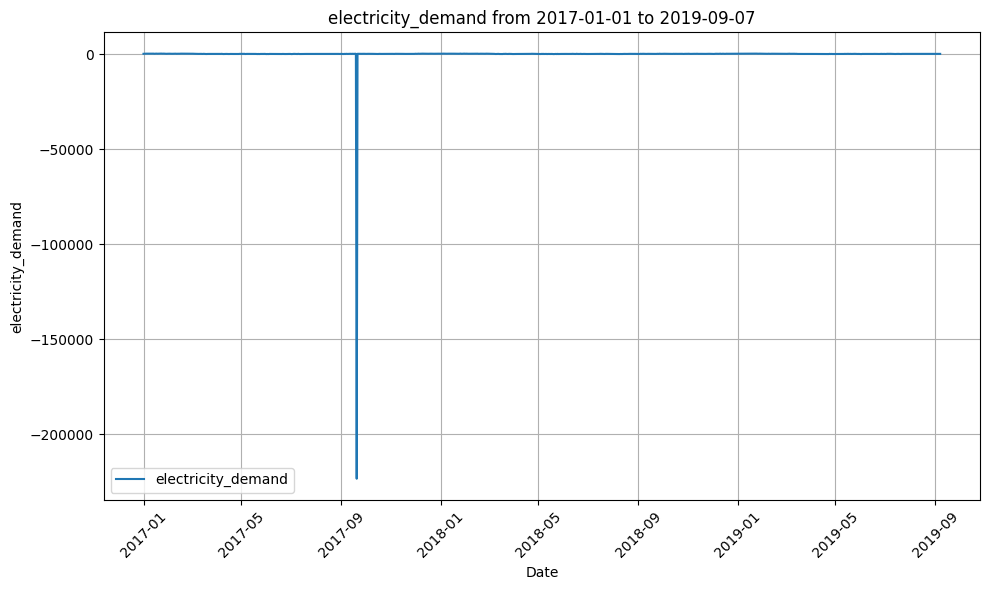

In [12]:
plot_feature_over_time(data, 'electricity_demand', '2017-01-01', '2019-09-07')

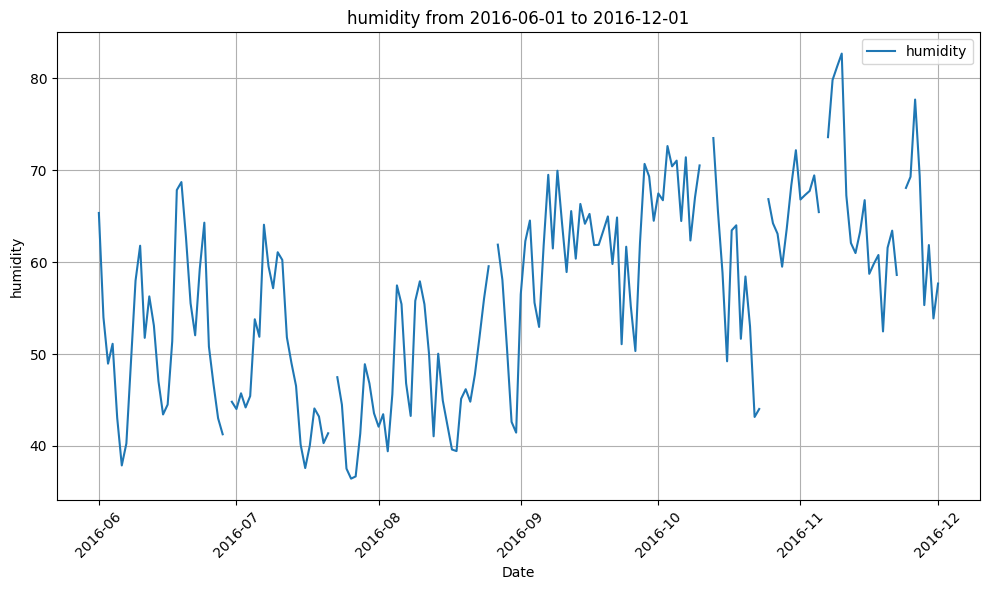

In [13]:
plot_feature_over_time(data, 'humidity', '2016-06-01', '2016-12-01')

# Analysis

### Inconsistencies

In [14]:
df= data.copy()

In [15]:
# shape du data
print("Forme du dataframe")
df.shape

Forme du dataframe


(2274, 16)

In [16]:
# Visualisation des 10 premières valeurs
print("Visualisation des 10 premières valeurs du dataframe\n")
df.head(10)

Visualisation des 10 premières valeurs du dataframe



,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
0,2015-01-08,Cloudy,69.304377,27.74 km/h,Moderate,0.369411,NaN,0.159977,0.118224,-0.444455,0.313675,0.106192,0.369430,1.279470,-0.384661,273.511353
1,2015-01-09,Sunny,55.955975,21.78 km/h,Moderate,2.009903,NaN,1.617242,NaN,2.160063,2.515627,1.867474,1.953165,1.878233,1.582365,258.827085
2,2015-01-10,Rainy,62.701614,6.83 m/s,Moderate,-2.603544,-2.422001,-3.685819,-2.392354,-1.936704,-2.950332,-3.074828,-2.698650,-2.354860,-2.770883,302.535033
3,2015-01-11,Snowy,60.375001,5.79 m/s,Moderate,-3.789836,-3.974054,-3.217545,-4.397143,-3.375188,-3.650454,-5.004991,-3.233724,-4.227899,NaN,296.270989
4,2015-01-12,Snowy,NaN,25.14 km/h,High,-2.405522,-2.161129,-2.880773,-2.587199,NaN,NaN,NaN,NaN,-2.790422,-2.033098,323.498090
5,2015-01-13,Cloudy,58.649834,28.75 km/h,High,-5.037719,-4.891658,-4.655657,-5.545906,NaN,-5.323173,-5.771092,NaN,-4.554718,-4.719306,303.623789
6,2015-01-13,Cloudy,58.649834,28.75 km/h,High,-5.037719,-4.891658,-4.655657,-5.545906,NaN,-5.323173,-5.771092,NaN,-4.554718,-4.719306,303.623789
7,2015-01-14,Rainy,69.235096,19.97 km/h,Moderate,-5.213824,-5.509778,NaN,NaN,NaN,-5.366943,-4.717191,-5.678185,-5.101359,-4.618354,321.299389
8,2015-01-15,Cloudy,67.523432,4.27 m/s,Moderate,-4.611890,NaN,-4.672053,-5.932923,-4.960255,-4.769734,-4.513605,NaN,-4.471426,-4.794511,311.156081
9,2015-01-16,Cloudy,67.978062,23.63 km/h,Moderate,-4.172215,-3.952440,NaN,NaN,-4.745741,-4.617068,-3.987911,-4.068369,NaN,-4.158880,311.350108


In [17]:
# Visualisation des 10 dernières valeurs
print("Visualisation des 10 premières valeurs du dataframe\n")
df.tail(10)

Visualisation des 10 premières valeurs du dataframe



,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
355,2019-12-22,Snowy,66.999266,5.70 m/s,Very High,-2.076660,-2.469803,-1.909701,-1.521222,-2.150103,-2.378944,-1.388864,-1.371192,-1.388138,-1.672714,NaN
356,2019-12-23,Cloudy,67.264508,NaN,Moderate,-1.957515,-1.141626,-1.807261,-2.366366,-1.603551,-2.747881,-2.128178,NaN,NaN,-1.656455,NaN
357,2019-12-24,Rainy,68.635600,6.27 m/s,Low,0.061618,-0.076395,0.530614,-0.226126,0.449155,0.745805,-0.299203,0.521866,1.093590,-0.370977,NaN
358,2019-12-25,Rainy,72.533215,7.24 m/s,Moderate,0.319429,-0.856147,0.085822,NaN,0.044269,-0.034963,1.027483,0.324912,0.067675,0.242769,NaN
359,2019-12-26,Snowy,NaN,23.86 km/h,Moderate,0.591722,0.203106,NaN,-0.722352,0.494092,0.323693,0.058856,0.573923,1.723748,0.471477,NaN
360,2019-12-27,Snowy,71.521673,22.78 km/h,Moderate,-1.674798,-2.338987,-1.829170,-0.881428,-0.571347,-2.231680,-1.962735,-1.602805,-1.264779,-1.705180,NaN
361,2019-12-28,Sunny,67.220123,18.33 km/h,High,3.209205,2.508606,2.195577,NaN,NaN,3.236547,3.181473,3.094390,NaN,3.475638,NaN
362,2019-12-29,Rainy,68.085227,7.24 m/s,Moderate,3.688132,3.919479,NaN,4.071717,4.365347,3.580358,3.404292,4.173461,3.755625,4.070333,NaN
363,2019-12-30,Cloudy,65.877214,7.67 m/s,Moderate,NaN,0.700484,NaN,-0.407440,-0.580917,-0.444730,0.034229,0.021199,-0.864657,NaN,NaN
364,2019-12-31,Cloudy,62.344026,30.99 km/h,Low,0.685487,0.080994,2.331834,1.093023,0.755162,0.971076,0.412485,0.169638,0.339503,-0.155684,NaN


In [18]:
# Visualisation de 10 lignes aléatoire
print("Visualisation de 10 lignes aléatoire\n")
df.sample(10)

Visualisation de 10 lignes aléatoire



,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
1548,2019-01-22,Snowy,65.954284,15.34 km/h,Low,-6.888944,-5.862797,-6.244590,-6.840761,-7.409948,-7.177018,-6.143978,-6.141696,-6.763025,-7.039993,329.573586
733,2016-12-12,Rainy,73.961445,6.52 m/s,High,-3.191186,-3.382603,-2.611530,NaN,-3.300099,-2.787250,NaN,-3.386794,-3.827098,NaN,336.770088
1348,2018-07-20,Sunny,52.205469,3.65 m/s,High,29.040879,NaN,29.260062,29.178973,29.460879,29.230058,29.442006,NaN,29.109180,28.706725,201.125526
169,2019-06-19,Sunny,55.697472,3.54 m/s,High,24.840863,24.810445,24.641852,24.299404,24.782468,NaN,NaN,24.733123,25.217249,24.581369,NaN
720,2016-11-29,Rainy,61.867749,3.58 km/h,Moderate,13.003029,13.114485,12.446940,12.597098,13.239138,12.997895,NaN,13.378397,12.500350,12.775868,232.248192
1524,2019-01-01,Rainy,72.985535,5.83 km/h,High,NaN,2.041746,1.992639,2.821712,1.636189,2.795024,1.674621,2.832348,2.058945,2.022864,305.910083
990,2017-08-13,Sunny,47.286226,8.00 km/h,High,NaN,37.267279,35.840683,36.642775,36.991290,36.775396,36.619306,NaN,37.125984,37.082001,241.866556
471,2016-04-08,Rainy,61.601472,1.30 m/s,Moderate,8.344752,8.319931,8.460382,8.205081,NaN,7.889837,7.843466,8.868810,8.982345,9.067556,206.154588
391,2016-01-22,Sunny,50.584659,17.49 km/h,Low,NaN,2.020048,2.304570,2.416705,NaN,1.203963,3.118484,1.885467,2.182437,NaN,262.078199
698,2016-11-09,Rainy,81.308666,3.25 m/s,Very High,NaN,12.251076,12.046078,12.087239,12.759127,11.805900,12.388973,11.593934,12.670283,12.542184,260.313416


In [19]:
# Infos générales sur le data
print("Infos générales sur le data")
df.info()

Infos générales sur le data
<class 'pandas.core.frame.DataFrame'>
Index: 2274 entries, 0 to 364
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       2274 non-null   datetime64[ns]
 1   weather_condition          2246 non-null   object        
 2   humidity                   2165 non-null   float64       
 3   wind_speed                 2167 non-null   object        
 4   oil_brent_price_indicator  2274 non-null   object        
 5   temperature_station1       1930 non-null   float64       
 6   temperature_station2       1946 non-null   float64       
 7   temperature_station3       1934 non-null   float64       
 8   temperature_station4       1954 non-null   float64       
 9   temperature_station5       1937 non-null   float64       
 10  temperature_station6       1953 non-null   float64       
 11  temperature_station7       1913 non-null   floa

In [20]:
# Statistique descriptive des colonnes de type string
# count= cardinal de var,unique les valeurs prises,top=valeur la plus fréquente et freq son nbre de frequence
df.describe(include=['object'])

,weather_condition,wind_speed,oil_brent_price_indicator
count,2246,2167,2274
unique,4,1172,5
top,Rainy,0.00 m/s,Moderate
freq,683,37,837


In [21]:
# Noms des colonnes de type string
nom_cols_string = df.select_dtypes(include=['object', 'string']).columns
nom_cols_string

Index(['weather_condition', 'wind_speed', 'oil_brent_price_indicator'], dtype='object')

In [22]:
for column in ['weather_condition', 'oil_brent_price_indicator']:
    print(f"{column}: {df[column].nunique()} - {df[column].unique()}")

weather_condition: 4 - ['Cloudy' 'Sunny' 'Rainy' 'Snowy' nan]
oil_brent_price_indicator: 5 - ['Moderate' 'High' 'Low' 'Very Low' 'Very High']


In [23]:
# Regrouper les valeur d'une variable en fonction des types 
for col in df.columns:
    print(f"Colonne: {col}")
    print("Nombre d'éléments par type de données :")
    print(df[col].apply(type).value_counts())
    print("-" * 40)


Colonne: date
Nombre d'éléments par type de données :
date
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    2274
Name: count, dtype: int64
----------------------------------------
Colonne: weather_condition
Nombre d'éléments par type de données :
weather_condition
<class 'str'>      2246
<class 'float'>      28
Name: count, dtype: int64
----------------------------------------
Colonne: humidity
Nombre d'éléments par type de données :
humidity
<class 'float'>    2274
Name: count, dtype: int64
----------------------------------------
Colonne: wind_speed
Nombre d'éléments par type de données :
wind_speed
<class 'str'>      2167
<class 'float'>     107
Name: count, dtype: int64
----------------------------------------
Colonne: oil_brent_price_indicator
Nombre d'éléments par type de données :
oil_brent_price_indicator
<class 'str'>    2274
Name: count, dtype: int64
----------------------------------------
Colonne: temperature_station1
Nombre d'éléments par type de données :
temperature

In [24]:
# Affiche toutes les n lignes où la valeur n'est pas un str
df[df['wind_speed'].apply(lambda x: not isinstance(x, str))].head(3)

,date,weather_condition,humidity,wind_speed,oil_brent_price_indicator,temperature_station1,temperature_station2,temperature_station3,temperature_station4,temperature_station5,temperature_station6,temperature_station7,temperature_station8,temperature_station9,temperature_station10,electricity_demand
14,2015-01-21,Snowy,69.124236,NaN,Very Low,-7.022809,-5.748753,-6.790255,-6.370345,-7.510294,-6.607260,-7.580778,-6.863959,NaN,-6.223665,303.019437
16,2015-01-23,Snowy,61.122616,NaN,High,-4.166763,-4.788067,NaN,-3.953095,-4.089131,-5.229595,-4.524754,-4.501473,NaN,NaN,357.519718
35,2015-02-11,Cloudy,64.211620,NaN,Low,0.383906,-1.312244,0.898632,0.140126,0.520272,NaN,0.983895,-0.068810,0.71187,0.103597,269.789743


### Handling Duplicates

In [25]:
# nombre de copies uniquement
nb_doublons_copies = df.duplicated().sum()
print("Nombre de doublons (copies uniquement) :", nb_doublons_copies)

Nombre de doublons (copies uniquement) : 90


### Handling Missing Values

In [26]:
# Nombre de valeurs manquantes par colonne
print("Nombre de valeurs manquantes par colonne:")
print(df.isnull().sum())

Nombre de valeurs manquantes par colonne:
date                           0
weather_condition             28
humidity                     109
wind_speed                   107
oil_brent_price_indicator      0
temperature_station1         344
temperature_station2         328
temperature_station3         340
temperature_station4         320
temperature_station5         337
temperature_station6         321
temperature_station7         361
temperature_station8         336
temperature_station9         350
temperature_station10        367
electricity_demand           365
dtype: int64


In [27]:
# Nombre de lignes avec au moins une valeur manquante
print("Nombre de lignes avec au moins une valeur manquante")
df.isnull().any(axis=1).sum()

Nombre de lignes avec au moins une valeur manquante


np.int64(1927)


Percentage of missing values per column:
date                          0.000000
weather_condition             1.231310
humidity                      4.793316
wind_speed                    4.705365
oil_brent_price_indicator     0.000000
temperature_station1         15.127529
temperature_station2         14.423923
temperature_station3         14.951627
temperature_station4         14.072120
temperature_station5         14.819701
temperature_station6         14.116095
temperature_station7         15.875110
temperature_station8         14.775726
temperature_station9         15.391381
temperature_station10        16.138962
electricity_demand           16.051011
dtype: float64


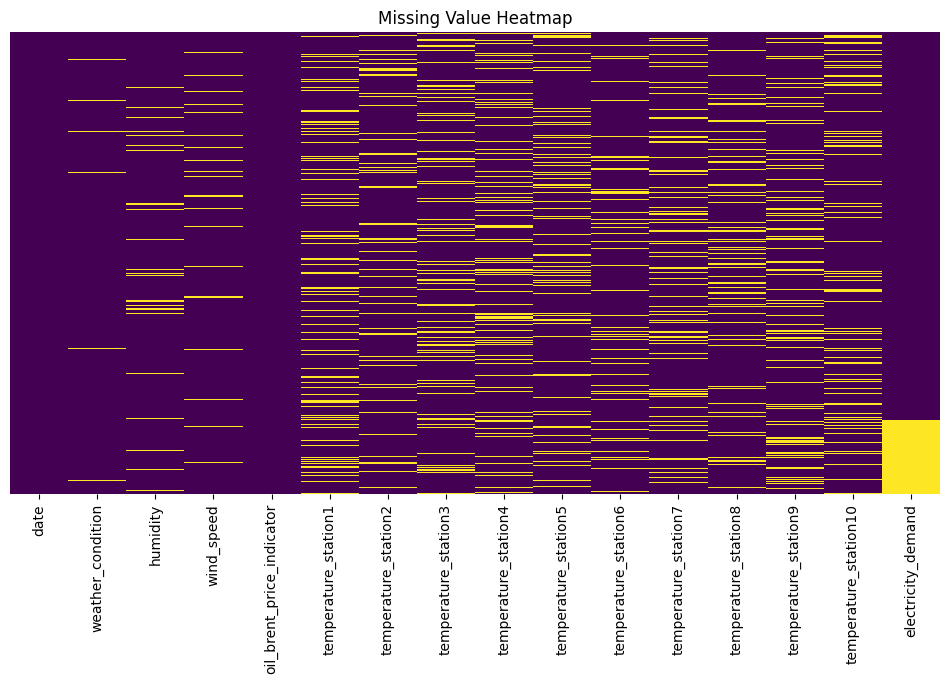

In [28]:
# Percentage of missing values per column
print("\nPercentage of missing values per column:")
percent_missing = df.isnull().mean() * 100
print(percent_missing)

# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap')
plt.show()


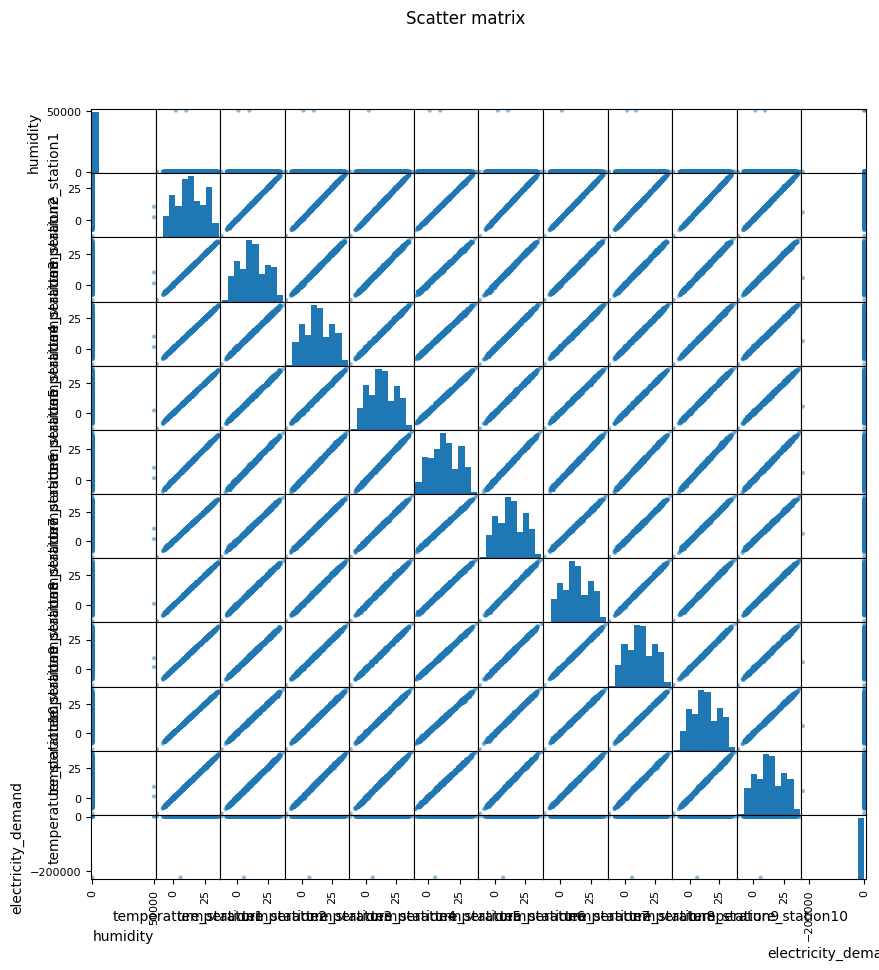

In [29]:
# permet de savoir si il faut utiliser le knn
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

scatter_matrix(df.select_dtypes(include='number'), figsize=(10, 10), diagonal='hist')
plt.suptitle("Scatter matrix")
plt.show()

### Handling Categorical Values

In [30]:
# Handling Categorical Values
for column in ['weather_condition', 'oil_brent_price_indicator']:
    print(f"{column}: {df[column].nunique()} - {df[column].unique()}")

weather_condition: 4 - ['Cloudy' 'Sunny' 'Rainy' 'Snowy' nan]
oil_brent_price_indicator: 5 - ['Moderate' 'High' 'Low' 'Very Low' 'Very High']


In [31]:
weather_to_num = {'Snowy': 0, 'Rainy': 1, 'Cloudy': 2, 'Sunny': 3}
oil_indicator_to_num = {'Very Low': 0, 'Low': 1, 'Moderate': 2, 'High': 3, 'Very High': 4}

def transfer_categorical(X):
    X_new = X.copy()

    # Remplacer les NaN par le mode de la colonne
    if 'weather_condition' in X_new.columns:
        mode_weather = X_new['weather_condition'].mode(dropna=True)[0]
        X_new['weather_condition'] = X_new['weather_condition'].fillna(mode_weather)
        X_new['weather_condition'] = X_new['weather_condition'].map(lambda x: weather_to_num.get(x, -1))

    if 'oil_brent_price_indicator' in X_new.columns:
        mode_oil = X_new['oil_brent_price_indicator'].mode(dropna=True)[0]
        X_new['oil_brent_price_indicator'] = X_new['oil_brent_price_indicator'].fillna(mode_oil)
        X_new['oil_brent_price_indicator'] = X_new['oil_brent_price_indicator'].map(lambda x: oil_indicator_to_num.get(x, -1))

    return X_new


### Handling Outliers

In [32]:
# Detecte le nbre de valeurs abérantes

### Data Preprocessing Evaluation Strategy

In [33]:
# Provide a complete data preprocessing transformations

In [34]:
# 1. Handle Inconsistencies
def handle_inconsistencies(X_train, y_train, X_val=None):
    
    def conversion_km_m(X):
        X = X.copy()  # Éviter de modifier le DataFrame original

        # Extraire les valeurs numériques et les unités de wind_speed
        X['value'] = X['wind_speed'].str.extract(r'([\d.]+)').astype(float)
        X['unit'] = X['wind_speed'].str.extract(r'([a-zA-Z/]+)')

        # Convertir toutes les vitesses en m/s
        def convert_to_mps(value, unit):
            if unit == 'km/h':
                return value / 3.6
            elif unit == 'm/s':
                return value
            else:
                return None  # ou NaN si tu veux

        X['wind_speed'] = X.apply(lambda row: convert_to_mps(row['value'], row['unit']), axis=1)

        # Supprimer les colonnes temporaires
        X.drop(columns=['value', 'unit'], inplace=True)

        return X

    # Nettoyage des colonnes catégorielles
    for df in [X_train] + ([X_val] if X_val is not None else []):
        df['weather_condition'] = df['weather_condition'].astype(str).str.strip().str.lower()
        df['oil_brent_price_indicator'] = df['oil_brent_price_indicator'].astype(str).str.strip().str.lower()

    # Conversion des vitesses
    X_train_clean = conversion_km_m(X_train)

    if X_val is not None:
        X_val_clean = conversion_km_m(X_val)
        return X_train_clean, y_train.copy(), X_val_clean
    else:
        return X_train_clean, y_train.copy()


In [35]:
# 2. Handling Duplicates
def handle_duplicates(X_train, y_train, X_val=None):
    # Supprimer les doublons dans X_train
    X_train_no_duplicate = X_train.drop_duplicates()
    # Garder les mêmes indices dans y_train que dans X_train_no_duplicate
    y_train_no_duplicate = y_train.loc[X_train_no_duplicate.index]

    if X_val is not None:
        # Supprimer les doublons dans X_val
        X_val_no_duplicate = X_val.drop_duplicates()
        return X_train_no_duplicate, y_train_no_duplicate, X_val_no_duplicate
    else:
        return X_train_no_duplicate, y_train_no_duplicate


In [36]:
# 3. Handling Missing Values
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

def handle_missing_values(X_train, y_train, X_val=None):
    def impute(X):
        # Séparer les colonnes numériques
        X_num = X.select_dtypes(include=['number'])
        X_cat = X.drop(columns=X_num.columns)  # colonnes non numériques

        # Standardisation
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns, index=X.index)

        # Imputation KNN
        imputer = KNNImputer(n_neighbors=3)
        X_imputed_scaled = pd.DataFrame(imputer.fit_transform(X_scaled), columns=X_num.columns, index=X.index)

        # Retour à l’échelle originale
        X_imputed = pd.DataFrame(scaler.inverse_transform(X_imputed_scaled), columns=X_num.columns, index=X.index)

        # Reconstruire le DataFrame avec les colonnes catégorielles
        X_new = pd.concat([X_imputed, X_cat], axis=1)

        return X_new

    # Imputer X_train
    X_train = impute(X_train)

    # Si X_val existe, l’imputer aussi
    if X_val is not None:
        X_val = impute(X_val)
        return X_train, y_train.copy(), X_val
    else:
        return X_train, y_train.copy()


In [37]:

def handle_categorical(X_train, y_train, X_val=None):
    X_train = X_train.copy()
    X_train = transfer_categorical(X_train)

    if X_val is not None:
        X_val = X_val.copy()
        X_val = transfer_categorical(X_val)
        
        return X_train, X_val
    else:
        return X_train






In [38]:
# 5. Handling Outliers
def handle_outliers(X_train, y_train, X_val=None):
    def find_outliers_iqr(series, threshold=1.5):
        """
        Détecte les outliers d'une série avec la méthode IQR.
        Retourne les index (et non les positions).
        """
        series = pd.Series(series).dropna()
        q1 = np.percentile(series, 25)
        q3 = np.percentile(series, 75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        return series[(series < lower) | (series > upper)].index

    # Colonnes numériques à traiter
    selected_columns = ['humidity', 'wind_speed', 'temperature_station1',
        'temperature_station2', 'temperature_station3', 'temperature_station4',
        'temperature_station5', 'temperature_station6', 'temperature_station7',
        'temperature_station8', 'temperature_station9', 'temperature_station10']

    # Collecte des index à supprimer
    outlier_indices = pd.Index([])

    for col in selected_columns:
        if col in X_train.columns:
            outlier_indices = outlier_indices.union(find_outliers_iqr(X_train[col]))

    # Ajouter les outliers dans y_train
    outlier_indices = outlier_indices.union(find_outliers_iqr(y_train))

    # Supprimer les lignes correspondantes
    X_train_cleaned = X_train.drop(index=outlier_indices, errors='ignore')
    y_train_cleaned = y_train.drop(index=outlier_indices, errors='ignore')

    if X_val is not None:
        return X_train_cleaned, y_train_cleaned, X_val.copy()
    else:
        return X_train_cleaned, y_train_cleaned


In [39]:
# 6. Feature Engineering

from sklearn.preprocessing import PolynomialFeatures


def feature_engineering(X_train, y_train, X_val=None):

    def add_time_features(data):
        new_data = data.copy()
        new_data['date'] = pd.to_datetime(new_data['date'], errors='coerce')  # robustesse
        new_data['dayofyear'] = new_data['date'].dt.dayofyear
        new_data['month'] = new_data['date'].dt.month
        new_data['day'] = new_data['date'].dt.day
        new_data['hour'] = new_data['date'].dt.hour
        new_data['dayofweek'] = new_data['date'].dt.dayofweek
        new_data['is_weekend'] = new_data['dayofweek'].isin([5, 6]).astype(int)
        new_data['week_of_year'] = new_data['date'].dt.isocalendar().week.astype(int)
        new_data['month_progress'] = new_data['date'].dt.day / new_data['date'].dt.days_in_month
        return new_data

    def add_aggregate_features(data):
        new_data = data.copy()

        temp_cols = [f'temperature_station{i}' for i in range(1, 11)]
        new_data['avg_temp'] = new_data[temp_cols].mean(axis=1)

        # Polynomial features
        poly = PolynomialFeatures(degree=2, include_bias=False)
        try:
            poly_features = poly.fit_transform(new_data[['avg_temp', 'humidity']])
            poly_feature_names = poly.get_feature_names_out(['avg_temp', 'humidity'])
            new_data[poly_feature_names] = poly_features
        except KeyError:
            print("⚠️ Colonne(s) manquante(s) pour les features polynomiales : 'avg_temp' ou 'humidity'")

        # Log de wind_speed
        if 'wind_speed' in new_data.columns:
            new_data['log_windspeed'] = np.log1p(new_data['wind_speed'])
        return new_data

    # Apply to training data
    X_train_new = X_train.copy()
    X_train_new = add_time_features(X_train_new)
    X_train_new = add_aggregate_features(X_train_new)

    # Apply to validation data (if exists)
    if X_val is not None:
        X_val_new = X_val.copy()
        X_val_new = add_time_features(X_val_new)
        X_val_new = add_aggregate_features(X_val_new)
        return X_train_new, y_train.copy(), X_val_new
    else:
        return X_train_new, y_train.copy()


In [40]:
# 7. Feature Selection and Dimensionality Reduction
def feature_selection(X_train, y_train, X_val=None):
    expected_columns = [
        'humidity', 'weather_condition', 'wind_speed', 'oil_brent_price_indicator',
        'temperature_station1', 'temperature_station2', 'temperature_station3',
        'temperature_station4', 'temperature_station5', 'temperature_station6',
        'temperature_station7', 'temperature_station8', 'temperature_station9', 'temperature_station10',
        'dayofyear', 'month', 'day', 'hour', 'dayofweek', 'is_weekend',
        'week_of_year', 'month_progress', 'avg_temp', 'avg_temp^2',
        'avg_temp humidity', 'humidity^2', 'log_windspeed'
    ]

    # Filtrer seulement les colonnes existantes
    available_columns = [col for col in expected_columns if col in X_train.columns]

    if X_val is not None:
        # S'assurer que X_val a aussi les colonnes disponibles
        common_columns = [col for col in available_columns if col in X_val.columns]
        return X_train[common_columns].copy(), X_val[common_columns].copy()
    else:
        return X_train[available_columns].copy()


In [41]:
def evaluate_pipeline(X, y, n_splits=5):

    ### call transformations here, if there is no learning and no need to be crossval
    X, y = handle_inconsistencies(X, y)
    X, y = handle_duplicates(X, y)
    X, y = handle_missing_values(X, y)
    X = handle_categorical(X, y)  # On réutilise bien X
    X, y = handle_outliers(X, y)
    X, y = feature_engineering(X, y)
    X = feature_selection(X, y)

    
    model = LinearRegression()
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    train_scores = []
    val_scores = []
    
    for fold, (train_index, val_index) in enumerate(tscv.split(X)):
        print(f"Processing fold {fold + 1}/{n_splits}...")
        
        # Split data into train and validation sets
        X_train, X_val = X.iloc[train_index].copy(), X.iloc[val_index].copy()
        y_train, y_val = y.iloc[train_index].copy(), y.iloc[val_index].copy()

        ### call transformations here, if there is learning
        # X_train, y_train, X_val = handle_inconsistencies(X_train, y_train, X_val)
        #X_train, y_train, X_val = handle_duplicates(X_train, y_train, X_val)
        # X_train, X_val = handle_missing_values(X_train, y_train, X_val)
        #X_train, X_val = handle_categorical(X_train, y_train, X_val)
        # X_train, y_train, X_val = handle_outliers(X_train, y_train, X_val)
        #X_train, y_train, X_val = feature_engineering(X_train, y_train, X_val)
        # X_train, X_val = feature_selection(X_train, y_train, X_val)
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on training set
        y_train_pred = model.predict(X_train)
        train_mse = mean_squared_error(y_train, y_train_pred)
        train_scores.append(train_mse)
        
        # Predict on validation set
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(y_val, y_val_pred)
        val_scores.append(val_mse)
        
        print(f"Fold {fold + 1} Train MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")
    
    # Compute mean, max, and min values for train and validation MSE
    mean_train_mse = np.mean(train_scores)
    max_train_mse = np.max(train_scores)
    min_train_mse = np.min(train_scores)
    
    mean_val_mse = np.mean(val_scores)
    max_val_mse = np.max(val_scores)
    min_val_mse = np.min(val_scores)
    
    # Print results
    print("\nTrain MSE:")
    print(f"Mean: {mean_train_mse:.4f}, Max: {max_train_mse:.4f}, Min: {min_train_mse:.4f}")
    
    print("\nValidation MSE:")
    print(f"Mean: {mean_val_mse:.4f}, Max: {max_val_mse:.4f}, Min: {min_val_mse:.4f}")
    
    return mean_val_mse  # Return mean validation MSE as the overall score

In [42]:
# Prepare X and y
X = df_train.copy().drop(columns=['electricity_demand'], axis=1)
y = df_train.copy().pop('electricity_demand')

# Run the evaluation
evaluate_pipeline(X, y)

Processing fold 1/5...
Fold 1 Train MSE: 475.6607, Validation MSE: 551.8912
Processing fold 2/5...
Fold 2 Train MSE: 493.3177, Validation MSE: 572.4238
Processing fold 3/5...
Fold 3 Train MSE: 510.3703, Validation MSE: 586.3239
Processing fold 4/5...
Fold 4 Train MSE: 523.0213, Validation MSE: 582.9165
Processing fold 5/5...
Fold 5 Train MSE: 531.7074, Validation MSE: 565.5637

Train MSE:
Mean: 506.8155, Max: 531.7074, Min: 475.6607

Validation MSE:
Mean: 571.8238, Max: 586.3239, Min: 551.8912


np.float64(571.8238199861241)

### Generating Submission File

In [43]:
# Train and submit your results

In [44]:
# Prepare X_train and y_train from your data
df_train =  pd.read_csv("module5_exercise_train.csv", sep=",")

X_train = df_train.drop(columns=['electricity_demand'], axis=1)
y_train = df_train['electricity_demand']

X_test =  pd.read_csv("module5_exercise_test.csv", sep=",")

In [45]:
def train_and_predict_to_submit(X_train, y_train, X_test):
    model = LinearRegression()
    
    X_train, y_train, X_test = handle_inconsistencies(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_duplicates(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_missing_values(X_train, y_train, X_test)
    X_train, X_test = handle_categorical(X_train, y_train, X_test)
    X_train, y_train, X_test = handle_outliers(X_train, y_train, X_test)
    X_train, y_train, X_test = feature_engineering(X_train, y_train, X_test)
    X_train, X_test = feature_selection(X_train, y_train, X_test)

    # Train the model on the entire training set
    print(f"Training model on entire dataset of shape: {X_train.shape}")
    model.fit(X_train, y_train)
    
    # Predict on the test set
    print(f"Predicting on test dataset of shape: {X_test.shape}")
    y_test_pred = model.predict(X_test)
    
    return y_test_pred

In [46]:
# Call serve_model to train and predict
y_test_pred = train_and_predict_to_submit(X_train, y_train, X_test)

Training model on entire dataset of shape: (1810, 27)
Predicting on test dataset of shape: (365, 27)


In [47]:
# Generating Submission File
submission = pd.DataFrame({
    'date': X_test['date'],
    'electricity_demand': y_test_pred
})

# Save the submission file
submission.to_csv('submission.csv', index=False, sep=',')
print("Submission file saved as 'submission.csv'.")

Submission file saved as 'submission.csv'.
